In [ ]:
import os, cv2
import numpy as np
import pandas as pd

DATA_DIRECTORY = "/content/gdrive/Shared drives/CS523/archive"

from google.colab import drive 
drive.mount('/content/gdrive')
#!ls "/content/gdrive/Shared drives/CS523/archive"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
metadata = pd.read_csv(os.path.join(DATA_DIRECTORY, 'metadata.csv'))

print(metadata)

     frame_id  sequence_id         tif_image_path              tif_mask_path  \
0           1            1    TIFF/Original/1.tif    TIFF/Ground Truth/1.tif   
1          10            1   TIFF/Original/10.tif   TIFF/Ground Truth/10.tif   
2         100            5  TIFF/Original/100.tif  TIFF/Ground Truth/100.tif   
3         101            5  TIFF/Original/101.tif  TIFF/Ground Truth/101.tif   
4         102            5  TIFF/Original/102.tif  TIFF/Ground Truth/102.tif   
..        ...          ...                    ...                        ...   
607        95            5   TIFF/Original/95.tif   TIFF/Ground Truth/95.tif   
608        96            5   TIFF/Original/96.tif   TIFF/Ground Truth/96.tif   
609        97            5   TIFF/Original/97.tif   TIFF/Ground Truth/97.tif   
610        98            5   TIFF/Original/98.tif   TIFF/Ground Truth/98.tif   
611        99            5   TIFF/Original/99.tif   TIFF/Ground Truth/99.tif   

           png_image_path             p

In [ ]:
# dataloader
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import transforms, datasets, models
import glob
from sklearn.model_selection import train_test_split

class Polyp_Dataset(Dataset) :
    def __init__(self, metadata, transform = None) :
        self.image_paths = metadata['png_image_path'].tolist()
        self.mask_paths = metadata['png_mask_path'].tolist()
        self.transform = transform

    def __len__(self) :
        return len(self.image_paths)     

    def __getitem__(self, idx) :
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        #index into path?
        image_FP = glob.glob((os.path.join(DATA_DIRECTORY, image_path)))
        mask_FP = glob.glob((os.path.join(DATA_DIRECTORY, mask_path)))
        image = cv2.cvtColor(cv2.imread(image_FP[0]),cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(mask_FP[0]),cv2.COLOR_BGR2RGB)
        
        if self.transform :
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask 

dataset = Polyp_Dataset(metadata=metadata)
unused_size = int(0.95 * len(dataset))
print(unused_size)
used_size = len(dataset) - unused_size
print(used_size)

unused_dataset, used_dataset = torch.utils.data.random_split(dataset, [unused_size, used_size])
train_size = int(0.8 * len(used_dataset))
print(train_size)
val_size = len(used_dataset) - train_size
print(val_size)
train_dataset, val_dataset = torch.utils.data.random_split(used_dataset, [train_size, val_size])
# print(dataset.getitem(0))

# train_set = dataset(2000, transform = trans)
# val_set = dataset(200, transform = trans)

# image_datasets = {
#     'train': train_set, 'val': val_set
# }
# random_state=42
# test_size=0.25
# xtrain, xtest, y_train, y_test = train_test_split(, y, test_size = test_size, train_size = 1-test_size, random_state = random_state)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=1 , shuffle=True, num_workers=0),
    'val': DataLoader(val_dataset, batch_size=1 , shuffle=True, num_workers=0)
}

581
31
24
7


In [ ]:
import matplotlib.pyplot as plt
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()    

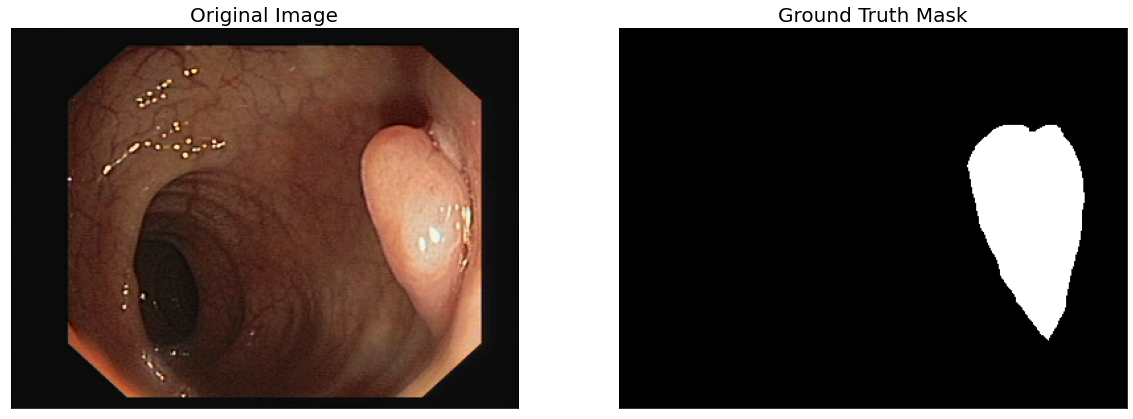

In [ ]:
dataset = Polyp_Dataset(metadata=metadata)
random_idx = np.random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]
visualize(
    original_image = image,
    ground_truth_mask = mask
)

In [ ]:
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms, datasets, models

# class SimDataset(Dataset):
#     def __init__(self, count, transform=None):
#         self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)
#         self.transform = transform

#     def __len__(self):
#         return len(self.input_images)

#     def __getitem__(self, idx):
#         image = self.input_images[idx]
#         mask = self.target_masks[idx]
#         if self.transform:
#             image = self.transform(image)

#         return [image, mask]

# # use the same transformations for train/val in this example
# trans = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
# ])

# train_set = SimDataset(2000, transform = trans)
# val_set = SimDataset(200, transform = trans)

# image_datasets = {
#     'train': train_set, 'val': val_set
# }

# batch_size = 25

# dataloaders = {
#     'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
#     'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
# }

In [ ]:
import torch
import torch.nn as nn
import copy
device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')

In [ ]:
class double_conv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.doubleconv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3, stride=1,padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels,out_channels,kernel_size=3, stride=1,padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True))
    
  def forward(self,x):
    return self.doubleconv(x)

In [ ]:
class up_conv(nn.Module):
  def __init__(self,in_channels, out_channels):
    super().__init__()
    self.upconv = nn.ConvTranspose2d(in_channels,out_channels,kernel_size=2, stride=2)

  def forward(self, x, skip):
    x = self.upconv(x)
    x = torch.cat([x,skip],1) #does order matter?
    return x

In [ ]:
class Unet(nn.Module):
  def __init__(self):
    super().__init__()

    self.double1 = double_conv(3, 64)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.double2 = double_conv(64, 128)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.double3 = double_conv(128,256)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.double4 = double_conv(256, 512)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.double5 = double_conv(512,1024)

    # Up
    self.up1 = up_conv(1024,512)
    self.updouble1 = double_conv(1024,512)
    self.up2 = up_conv(512,256)
    self.updouble2 = double_conv(512,256)
    self.up3 = up_conv(256,128)
    self.updouble3 = double_conv(256,128)
    self.up4 = up_conv(128,64)
    self.updouble4 = double_conv(128,64)

    # last convolution
    self.lastconv = nn.Conv2d(64,3,1)

  def forward(self, x):
    d1 = self.double1(x)
    d2 = self.double2(self.pool1(d1))
    d3 = self.double3(self.pool2(d2))
    d4 = self.double4(self.pool3(d3))
    d5 = self.double5(self.pool4(d4))
    # up bit - theres some concatenation involved. 
    u1_up = self.up1(d5,d4)
    u1 = self.updouble1(u1_up)
    u2 = self.updouble2(self.up2(u1,d3))
    u3 = self.updouble3(self.up3(u2,d2))
    u4 = self.updouble4(self.up4(u3,d1))
    u_final = self.lastconv(u4)

    return u_final

  

In [ ]:
model = Unet()

# x = torch.randn(size=(1, 3, 512, 512), dtype=torch.float32)
# with torch.no_grad():
#     out = model(x)

# print(f'Out: {out.shape}')

In [ ]:
from torchsummary import summary
summary(model, input_size= (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
       double_conv-7         [-1, 64, 224, 224]               0
         MaxPool2d-8         [-1, 64, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]          73,856
      BatchNorm2d-10        [-1, 128, 112, 112]             256
             ReLU-11        [-1, 128, 112, 112]               0
           Conv2d-12        [-1, 128, 112, 112]         147,584
      BatchNorm2d-13        [-1, 128, 112, 112]             256
             ReLU-14        [-1, 128, 1

In [ ]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [ ]:
from collections import defaultdict
import torch.nn.functional as F

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

In [ ]:
def train_model(model, optimizer, scheduler, num_epochs=2):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = torch.transpose(inputs,1,3).float().to(device)
                labels = torch.transpose(labels,1,3).float().to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)
                print(loss)

            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum =0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1], gamma=0.1)
best_model = train_model(model,optimizer,scheduler)

Epoch 0/1
----------
LR 0.0001


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(-5.0146, grad_fn=<AddBackward0>)
tensor(0.2961, grad_fn=<AddBackward0>)
tensor(-0.3281, grad_fn=<AddBackward0>)
tensor(-16.0080, grad_fn=<AddBackward0>)
tensor(-13.1819, grad_fn=<AddBackward0>)
tensor(-8.0584, grad_fn=<AddBackward0>)
tensor(-7.4672, grad_fn=<AddBackward0>)
tensor(-21.7025, grad_fn=<AddBackward0>)
tensor(-13.1804, grad_fn=<AddBackward0>)
tensor(-31.1101, grad_fn=<AddBackward0>)
tensor(-45.3011, grad_fn=<AddBackward0>)
tensor(-13.5499, grad_fn=<AddBackward0>)
tensor(-9.0337, grad_fn=<AddBackward0>)
tensor(-22.8829, grad_fn=<AddBackward0>)
tensor(-33.0273, grad_fn=<AddBackward0>)
tensor(-13.7538, grad_fn=<AddBackward0>)
tensor(-24.1445, grad_fn=<AddBackward0>)
tensor(-11.8978, grad_fn=<AddBackward0>)
tensor(-13.5707, grad_fn=<AddBackward0>)
tensor(-10.1478, grad_fn=<AddBackward0>)
tensor(-29.4806, grad_fn=<AddBackward0>)
tensor(-9.7739, grad_fn=<AddBackward0>)
tensor(-13.0205, grad_fn=<AddBackward0>)
tensor(-44.9954, grad_fn=<AddBackward0>)
tensor(-50.9371)
tensor(

In [ ]:
testtensor = torch.zeros([1,288,384,3])
print(torch.transpose(testtensor,1,3).shape)

torch.Size([1, 3, 384, 288])
